In [1]:
import mxnet as mx
from mxnet import gluon, autograd, nd
from mxnet.gluon import nn,utils 
import mxnet.ndarray as F
import numpy as np
import os, sys
from tqdm import tqdm

import pickle
import random
from tqdm import tqdm

In [2]:
GPU_COUNT = 4 # increase if you have more
ctx = [mx.gpu(i) for i in range(GPU_COUNT)]

In [3]:
class ConvInputModel(nn.HybridBlock):
    def __init__(self,**kwargs):
        super(ConvInputModel,self).__init__(**kwargs)
                
        with self.name_scope():
            self.conv1 = nn.Conv2D(channels=24,kernel_size=3,strides=2,padding=1,activation='relu')
            self.bn1 = nn.BatchNorm()
            self.conv2 = nn.Conv2D(channels=24,kernel_size=3,strides=2,padding=1,activation='relu')
            self.bn2 = nn.BatchNorm()
            self.conv3 = nn.Conv2D(channels=24,kernel_size=3,strides=2,padding=1,activation='relu')
            self.bn3 = nn.BatchNorm()
            self.conv4 = nn.Conv2D(channels=24,kernel_size=3,strides=2,padding=1,activation='relu')
            self.bn4 = nn.BatchNorm()
            
    def forward(self,x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.conv4(x)
        x = self.bn4(x)
        
        return x

In [4]:
class FCOutputModel(nn.HybridBlock):
    def __init__(self,**kwargs):
        super(FCOutputModel,self).__init__(**kwargs)
        
        with self.name_scope():
            self.fc2 = nn.Dense(256)
            self.fc3 = nn.Dense(10)
    
    def forward(self,x):
        x = self.fc2(x)
        x = F.relu(x)
        x = F.Dropout(x)
        x = self.fc3(x)
        
        #return F.log_softmax(x)
        return x

In [5]:
class RN_Model(nn.HybridBlock):
    def __init__(self,args,**kwargs):
        super(RN_Model,self).__init__(**kwargs)
    
        with self.name_scope():
            self.conv = ConvInputModel()
            
            self.g_fc1 = nn.Dense(256,activation='relu')
            self.g_fc2 = nn.Dense(256,activation='relu')
            self.g_fc3 = nn.Dense(256,activation='relu')
            self.g_fc4 = nn.Dense(256,activation='relu')
            
            self.f_fc1 = nn.Dense(256,activation='relu')
            
            
            #self.coord_oi = gluon.Parameter('oi',shape=(args.batch_size,2))
            #self.coord_oj = gluon.Parameter('oj',shape=(args.batch_size,2))
            #self.coord_tensor = gluon.Parameter('coord_tensor',shape=(args['batch_size'],25,2))
        
            ##initialize
            #self.coord_oi.intialize()
            #self.coord_oj.intialize()
            #self.coord_tensor.initialize(ctx=ctx)
            
            
            
            self.fcout = FCOutputModel()
            
            

    def forward(self,x,qst):
        
        self.coord_tensor = F.zeros((args['batch_size'], 25, 2),ctx=mx.gpu())
         # prepare coord tensor
        def cvt_coord(i):
                return [(i/5-2)/2., (i%5-2)/2.]
        
        for i in range(25):
            self.coord_tensor[:,i,:] = F.array( cvt_coord(i) )
        #self.coord_tensor.set_data(F.array(np_coord_tensor).copy())
        
        #input size = (64 * 3 * 75 * 75)
        x = self.conv(x) ## x = (64 * 24 * 5 * 5)
                
        ##g part
        mb = x.shape[0]
        n_channels = x.shape[1]
        d = x.shape[2]
        
        x_flat = x.reshape(shape=(mb,n_channels,d*d))
        x_flat = F.swapaxes(x_flat,1,2) ## (64 * 25 * 24)
        
        ##add coordinates
        x_flat = F.concat(x_flat,self.coord_tensor,dim=2)
        #x_flat = F.concat(x_flat,np_coord_tensor,dim=2)
        
        ##add question
        qst = qst.expand_dims(1)
        qst = F.repeat(qst,repeats=25,axis=1)
        qst =qst.expand_dims(2)
        
        # cast all pairs against each other
        x_i = x_flat.expand_dims(1)
        x_i = F.repeat(x_i,repeats=25,axis=1)
        
        x_j = x_flat.expand_dims(2)
        x_j = F.concat(x_j,qst,dim=3)
        x_j = F.repeat(x_j,repeats=25,axis=2)
        
        #concatenate all
        x_full = F.concat(x_i,x_j,dim=3)
        
        #reshape and apply dnn network
        x_ = x_full.reshape((-1,63))
        x_ = self.g_fc1(x_)
        x_ = self.g_fc2(x_)
        x_ = self.g_fc3(x_)
        x_ = self.g_fc4(x_)
        
        x_g = x_.reshape((mb,-1,256))
        x_g = x_g.sum(1)
        
        ##### f part #######
        x_f = self.f_fc1(x_g)
        
        return self.fcout(x_f)
            

In [6]:
def load_data():
    print('loading data...')
    dirs = os.getcwd()
    filename = os.path.join(dirs,'sort-of-clevr.pickle')
    with open(filename, 'rb') as f:
        train_datasets, test_datasets = pickle.load(f)
    rel_train = []
    rel_test = []
    norel_train = []
    norel_test = []
    print('processing data...')

    for img, relations, norelations in train_datasets:
        img = np.swapaxes(img,0,2)
        for qst,ans in zip(relations[0], relations[1]):
            rel_train.append((img,qst,ans))
        for qst,ans in zip(norelations[0], norelations[1]):
            norel_train.append((img,qst,ans))

    for img, relations, norelations in test_datasets:
        img = np.swapaxes(img,0,2)
        for qst,ans in zip(relations[0], relations[1]):
            rel_test.append((img,qst,ans))
        for qst,ans in zip(norelations[0], norelations[1]):
            norel_test.append((img,qst,ans))
    
    return (rel_train, rel_test, norel_train, norel_test)

In [7]:
rel_train, rel_test, norel_train, norel_test = load_data()

loading data...
processing data...


In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [9]:
def display_image(data):
    img = data[0]
    img = np.swapaxes(img,0,2)
    plt.imshow((img * 255.0).astype('uint8'))

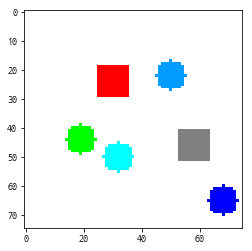

In [10]:
display_image(rel_train[11])

In [11]:
args = dict()
args['batch_size'] = 64
args['epoches'] = 10

In [12]:
#coord_tensor = F.zeros((args['batch_size'], 25, 2))
#coord_tensor = gluon.utils.split_and_load(coord_tensor,ctx)
model = RN_Model(args)

In [13]:
#parameter initialozation
model.collect_params().initialize(ctx=ctx)

In [14]:
#set optimizer
trainer = gluon.Trainer(model.collect_params(),optimizer='adam',optimizer_params={'learning_rate':0.0001})

In [15]:
#define loss function
loss = gluon.loss.SoftmaxCrossEntropyLoss()

In [19]:
# prepare coord tensor
def cvt_coord(i):
    return [(i/5-2)/2., (i%5-2)/2.]

In [16]:
def cvt_data_axis(data):
    img = [e[0] for e in data]
    qst = [e[1] for e in data]
    ans = [e[2] for e in data]
    return (img,qst,ans)

In [17]:
def ndarray_conv(data, i,bs,ctx):
    img = F.array(np.asarray(data[0][bs*i:bs*(i+1)]))
    qst = F.array(np.asarray(data[1][bs*i:bs*(i+1)]))
    ans = F.array(np.asarray(data[2][bs*i:bs*(i+1)]))

    return img, qst, ans

In [18]:
for epoch in tqdm(range(args['epoches'])):
    cumulative_rel_loss = 0.0
    cumulative_norel_loss = 0.0
    
    input_rel_train = rel_train.copy()
    input_norel_train = norel_train.copy()
    
    #shuffle data
    random.shuffle(input_rel_train)
    random.shuffle(input_norel_train)
    
    rel = cvt_data_axis(input_rel_train)
    norel = cvt_data_axis(input_norel_train)
    
    for batch_idx in tqdm(range(len(rel[0]) // (args['batch_size'] * 4))):
        input_rel_img, input_rel_qst, rel_label = ndarray_conv(rel,batch_idx,args['batch_size']*4,ctx)
        
        #data split
        input_rel_img = gluon.utils.split_and_load(input_rel_img,ctx)
        input_rel_qst = gluon.utils.split_and_load(input_rel_qst,ctx)
        rel_label = gluon.utils.split_and_load(rel_label,ctx)
        coord_tensor = F.zeros((args['batch_size'] * 4, 25, 2))
        coord_tensor = gluon.utils.split_and_load(coord_tensor,ctx)
        with autograd.record():
            rel_losses = [loss(model(X,Y,W),X) for X, Y, W, Z in zip(input_rel_img,input_rel_qst,coord_tensor,rel_label)]
            #rel_output = model(input_rel_img,input_rel_qst)
            #rel_loss = loss(rel_output,rel_label)
        for l in rel_losses:
            l.backward()
        #rel_loss.backward()
        trainer.step(args['batch_size'])
        for l in rel_losses:
            cumulative_rel_loss += nd.sum(l).asscalar()
        #cumulative_rel_loss += nd.sum(rel_loss).asscalar()
        
        #input_norel_img, input_norel_qst, norel_label = ndarray_conv(norel,batch_idx,args['batch_size'],ctx)  
       # with autograd.record():
       #     norel_output = model(input_norel_img,input_norel_qst)
       #     norel_loss = gluon.loss.SoftmaxCrossEntropyLoss()(norel_output,norel_label)
       # norel_loss.backward()
       # trainer.step(args['batch_size'])
       # cumulative_norel_loss += nd.sum(norel_loss).asscalar()
    print("Epoch {e}. rel_Loss: {rl} ".format(e=epoch, rl=cumulative_loss/(len(rel[0]) // (args['batch_size'] * 4))))
    #print("Epoch {e}. rel_Loss: {rl} norel_Loss: {nrl}".format(e=epoch, rl=cumulative_loss/(len(rel[0]) // args['batch_size']), nrl=cumulative_loss/ (len(rel[0]) // args['batch_size'])))

  0%|          | 0/382 [00:00<?, ?it/s]



MXNetError: Shape inconsistent, Provided = [64,3,75,75], inferred shape=[64]

In [21]:
len(input_rel_img)

4

In [38]:
coord_tensor[0].shape

(16, 25, 2)

In [493]:
len(x_data_l)

2

In [488]:
ctx

[cpu(0), cpu(1)]

In [439]:
input_norel_train

NameError: name 'input_norel_train' is not defined

In [436]:
input_rel_train = rel_train.copy()

In [231]:
input_data = nd.random_normal(shape=(64,3,75,75))
input_qst = nd.random_normal(shape=(64,11))

In [277]:
args

{'batch_size': 64}

In [338]:
tmp1 = RN(args)

In [339]:
tmp1.collect_params().initialize()

In [340]:
out = tmp1(input_data,input_qst)

In [341]:
out.shape

(64, 10)

In [149]:
input_data.shape[1]

3

In [150]:
x = tmp(input_data)

In [151]:
x.shape

(64, 24, 5, 5)

In [152]:
mb = x.shape[0]
n_channels = x.shape[1]
d = x.shape[2]

In [155]:
x_flat = x.reshape(shape=(mb,n_channels,d*d))
x_flat = F.swapaxes(x_flat,1,2)

In [156]:
x_flat.shape

(64, 25, 24)

In [160]:
a = np.arange(64*25*24)

In [164]:
a = a.reshape((-1,25,24))

In [165]:
a.shape

(64, 25, 24)

In [213]:
a_1 = np.expand_dims(a,axis=1)

In [214]:
a_1.shape

(64, 1, 25, 24)

In [215]:
a_2 = np.repeat(a_1,repeats=25,axis=1)

In [216]:
a_2.shape

(64, 25, 25, 24)

In [226]:
a_2[0][0].shape

(25, 24)

In [74]:
x_flat.shape

(64, 25, 24)

In [169]:
#arbitrary coordinate
def cvt_coord(i):
    #d=5, 
    return [(i/5-2)/2., (i%5-2)/2.]

In [170]:
np_coord_tensor = np.zeros((64, 25, 2))
for i in range(25):
    np_coord_tensor[:,i,:] = np.array( cvt_coord(i) )

In [171]:
np_coord_tensor = F.array(np_coord_tensor)

In [178]:
x_flat = F.concat(x_flat,np_coord_tensor,dim=2)

In [227]:
#기준 위치
x_i = x_flat.expand_dims(1)
x_i = F.repeat(x_i,repeats=25,axis=1)
x_i[2].shape

(25, 25, 26)

In [228]:
x_j = x_flat.expand_dims(2)

In [230]:
x_j.shape

(64, 25, 1, 26)

In [293]:
qst = input_qst.expand_dims(1)
qst = F.repeat(qst,repeats=25,axis=1)
qst = qst.expand_dims(2)

In [243]:
qst.shape

(64, 25, 1, 11)

In [245]:
x_j = F.concat(x_j,qst,dim=3)

In [246]:
x_j.shape

(64, 25, 1, 37)

In [247]:
x_j = F.repeat(x_j,repeats=25,axis=2)

In [248]:
x_j.shape

(64, 25, 25, 37)

In [249]:
x_full = F.concat(x_i,x_j,dim=3)

In [250]:
x_full.shape

(64, 25, 25, 63)

In [251]:
x_ = x_full.reshape((-1,63))

In [254]:
x_full.shape

(64, 25, 25, 63)

In [252]:
x_.shape

(40000, 63)

In [253]:
mb * d*d*d*d

40000

In [256]:
x_g = x_.reshape((64,-1,63))

In [257]:
x_g.shape

(64, 625, 63)

In [269]:
F.s

(64, 63)

In [265]:
x_g.sum(1).squeeze()

AttributeError: 'NDArray' object has no attribute 'squeeze'

In [260]:
tmp = np.arange(10)
tmp = tmp.reshape(5,2)

In [261]:
tmp

array([[0, 1],
       [2, 3],
       [4, 5],
       [6, 7],
       [8, 9]])

In [264]:
tmp.sum(1)

array([ 1,  5,  9, 13, 17])

In [335]:
F.zeros((1,2))


[[ 0.  0.]]
<NDArray 1x2 @cpu(0)>

In [336]:
np_coord_tensor


[[[-1.         -1.        ]
  [-0.89999998 -0.5       ]
  [-0.80000001  0.        ]
  ..., 
  [ 1.20000005  0.        ]
  [ 1.29999995  0.5       ]
  [ 1.39999998  1.        ]]

 [[-1.         -1.        ]
  [-0.89999998 -0.5       ]
  [-0.80000001  0.        ]
  ..., 
  [ 1.20000005  0.        ]
  [ 1.29999995  0.5       ]
  [ 1.39999998  1.        ]]

 [[-1.         -1.        ]
  [-0.89999998 -0.5       ]
  [-0.80000001  0.        ]
  ..., 
  [ 1.20000005  0.        ]
  [ 1.29999995  0.5       ]
  [ 1.39999998  1.        ]]

 ..., 
 [[-1.         -1.        ]
  [-0.89999998 -0.5       ]
  [-0.80000001  0.        ]
  ..., 
  [ 1.20000005  0.        ]
  [ 1.29999995  0.5       ]
  [ 1.39999998  1.        ]]

 [[-1.         -1.        ]
  [-0.89999998 -0.5       ]
  [-0.80000001  0.        ]
  ..., 
  [ 1.20000005  0.        ]
  [ 1.29999995  0.5       ]
  [ 1.39999998  1.        ]]

 [[-1.         -1.        ]
  [-0.89999998 -0.5       ]
  [-0.80000001  0.        ]
  ..., 
  [ 1.2000

In [495]:
l =  [ 0.1,0.2,0.3,0.1]

In [496]:
sum(l)

0.7000000000000001

In [497]:
rel_loss


[ 0.8638171   2.19165182  2.2794652   1.93392825  1.67920315  0.66911793
  3.90173435  0.64199305  0.81745774  1.59799993  3.23418808  1.56617522
  2.06428051  3.23854423  2.92173195  1.44944358  2.17308736  1.64353788
  1.88338935  4.87075329  0.95933688  2.94571495  5.46033525  1.49808955
  2.86410332  3.43375087  1.05889845  1.29653597  1.77711678  1.50299072
  0.64863592  2.32399464  1.25179076  2.41068554  4.2410779   2.47937489
  1.86308432  1.49021065  3.76145196  2.03952098  1.21094859  0.54347241
  2.50145411  2.61306548  4.89950943  0.86969173  1.96627736  1.082003
  1.3611505   1.78630376  0.76254135  0.91958207  0.96428132  1.07121336
  1.87720156  2.15225267  1.05590534  0.89416265  4.75213766  2.61064196
  1.46157229  3.2163353   1.7334311   0.36240873]
<NDArray 64 @cpu(0)>

In [36]:
 a = F.zeros((args['batch_size'], 25, 2))

In [37]:
b = gluon.utils.split_and_load(a,ctx)

In [40]:
b[1]


[[[ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]]

 [[ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]]

 [[ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]]

 [[ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 0.  0

In [24]:
64/4

16.0